In [2]:
import numpy as np
from sympy import Line
import torch
from torch import Tensor
import sys, os
import pickle
import scipy
from scipy.optimize import curve_fit
import torch.optim as optim

from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS, GaussLegendre # The available integrators
from torchquad.utils.set_precision import set_precision
import torchquad
from functools import partial
import matplotlib.pyplot as plt
from pathlib import  Path
import torch.nn as nn

from LinearAxion_NN import LinearAxion_NN, S_integral, l_integral, _h, _f
from LinearAxion import power_law_fit, f_for_fit, get_thermal_entropy

/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789122112/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [3]:
# Use this to enable GPU support and set the floating point precision
set_up_backend("torch", data_type="float64")
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
def calc_loss(S_pred, l_pred, s_thermal_pred, s_thermal_true, Sl_fit_func, popt):
    """
    Loss function for the model. (4.11) in paper
    """
    interpolated_S = Sl_fit_func(l_pred, *popt)

    # mae
    S_loss = torch.mean(torch.abs(S_pred - interpolated_S))
    s_thermal_loss = torch.mean(torch.abs(s_thermal_pred - s_thermal_true))
    loss = S_loss + s_thermal_loss
    return {"S_loss": S_loss, "s_thermal_loss": s_thermal_loss, "loss": loss}

def interpolate_S_l(data):
    popt, pcov = power_law_fit(data)
    return popt

In [89]:
# load data
dir = Path("data")
path = dir / "data.pkl"
print(f"Loading data from {path}")
data_loaded = pickle.load(open(path, "rb"))
mu = 0.5
beta = 0.5
N_zstar_points = 400
clipping_value = 0.1 # arbitrary value of your choosing
S_true = data_loaded[(mu, beta)]["SFinite"]
l_true = data_loaded[(mu, beta)]["l"]
zstar = data_loaded[(mu, beta)]["zstar"]
s_thermal_true = torch.tensor(data_loaded[(mu, beta)]["s_thermal"], requires_grad=False)
print(f"{zstar.shape=}, {S_true.shape=}, {s_thermal_true.shape=}")

print(data_loaded[(mu, beta)]["SFinite"])
print(data_loaded[(mu, beta)]["l"])
print(data_loaded[(mu, beta)]["zstar"])
# S_l_interpolated = interpolate_S_l(data_loaded[(mu, beta)])
popt = interpolate_S_l(data_loaded[(mu, beta)])

zstar_list = torch.tensor(np.linspace(0.10, 0.999, N_zstar_points), requires_grad=False)

Loading data from data/data.pkl
zstar.shape=(5000,), S_true.shape=(5000,), s_thermal_true.shape=torch.Size([])
[-9.99901821e+05 -3.24249766e+03 -1.54747910e+03 ...  9.64715542e-01
  9.87172398e-01  1.01134890e+00]
[9.98927944e-07 2.32016718e-04 4.63190921e-04 ... 3.59454715e+00
 3.63901050e+00 3.68689605e+00]
[1.0000000e-06 2.0103960e-04 4.0107922e-04 ... 9.9959892e-01 9.9979895e-01
 9.9999899e-01]


In [90]:
def h_helper(z):
    return _h(model, z)

In [91]:
epochs = 150
model = LinearAxion_NN(input_dim=1, output_dim=1, hidden_layers=[20, 20, 20])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40, 60, 70, 80, 90, 110, 120, 130], gamma=0.5)
loss_hist = []
s_thermal_loss_hist = []
S_loss_hist = []
lr_hist = []
for epoch in range(epochs):
    zstar_list_noise = zstar_list + torch.randn_like(zstar_list) * 0.005 # add some noise
    zstar_list_noise = torch.clamp(zstar_list_noise, min=0.10, max=0.9999)  # avoid numerical issues
    if epoch == epochs:
        N_zstar_points = 1000
        zstar_list = torch.tensor(np.linspace(0.10, 0.999, N_zstar_points), requires_grad=False)
        zstar_list_noise = torch.tensor(np.linspace(0.10, 0.999, N_zstar_points), requires_grad=False)
    S_pred = S_integral(model, zstar_list_noise, N_GL=12)
    l_pred = l_integral(model, zstar_list_noise, N_GL=12)
    s_thermal_pred = get_thermal_entropy(h_helper, zh=torch.tensor(1.0))
    losses = calc_loss(S_pred, l_pred, s_thermal_pred, s_thermal_true, f_for_fit, popt)
    loss = losses["loss"]
    lr = optimizer.param_groups[0]["lr"]
    print(f"e={epoch}/{epochs}, s_thermal={s_thermal_pred.item():.3f}, lr={lr}, loss={loss.item():.3f}")

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
    optimizer.step()
    scheduler.step()

    loss_hist.append(loss.item())
    s_thermal_loss_hist.append(losses["s_thermal_loss"].item())
    S_loss_hist.append(losses["S_loss"].item())
    lr_hist.append(lr)
    if loss.item is None or np.isnan(loss.item()):
        print("Loss is None or NaN, stopping training.")
        break


/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/autoray/autoray.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/torchquad/integration/utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


e=0/150, s_thermal=0.971, lr=0.01, loss=0.213
e=1/150, s_thermal=1.081, lr=0.01, loss=0.303
e=2/150, s_thermal=1.055, lr=0.01, loss=0.248
e=3/150, s_thermal=0.978, lr=0.01, loss=0.165
e=4/150, s_thermal=0.982, lr=0.01, loss=0.149
e=5/150, s_thermal=1.022, lr=0.01, loss=0.155
e=6/150, s_thermal=1.024, lr=0.01, loss=0.139
e=7/150, s_thermal=0.995, lr=0.01, loss=0.086
e=8/150, s_thermal=0.997, lr=0.01, loss=0.062
e=9/150, s_thermal=1.029, lr=0.01, loss=0.078
e=10/150, s_thermal=1.028, lr=0.01, loss=0.051
e=11/150, s_thermal=0.996, lr=0.01, loss=0.028
e=12/150, s_thermal=0.997, lr=0.01, loss=0.047
e=13/150, s_thermal=1.028, lr=0.01, loss=0.073
e=14/150, s_thermal=1.025, lr=0.01, loss=0.071
e=15/150, s_thermal=0.995, lr=0.01, loss=0.053
e=16/150, s_thermal=0.994, lr=0.01, loss=0.041
e=17/150, s_thermal=1.016, lr=0.01, loss=0.034
e=18/150, s_thermal=1.010, lr=0.01, loss=0.025
e=19/150, s_thermal=0.983, lr=0.01, loss=0.028
e=20/150, s_thermal=0.979, lr=0.005, loss=0.032
e=21/150, s_thermal=0.

/home/bigbogo/Documents/Projects/HoloML/LinearAxion/LinearAxion.py:166: RuntimeWarning: divide by zero encountered in scalar power
  return cn1 * x**(-1) + c0 + c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4 + c5 * x**5


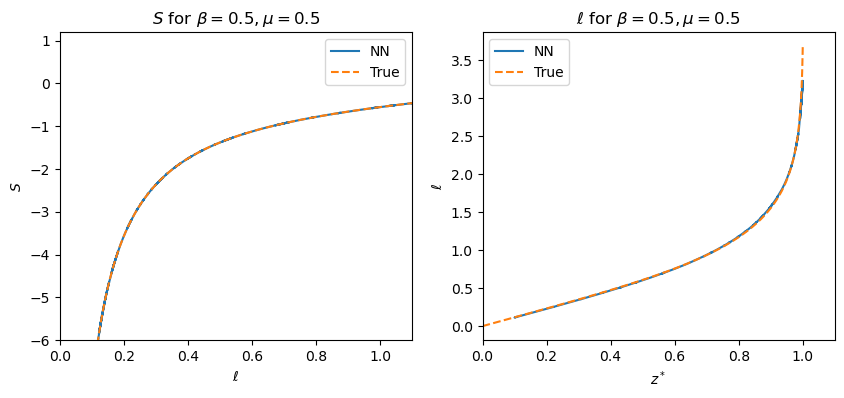

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

plt.sca(axs[0])
plt.plot(l_pred.detach().cpu().numpy(), S_pred.detach().cpu().numpy(), label="NN")
plt.plot(l_true, S_true, label="True", ls="--")
l_list = np.linspace(0, 3.5, 100)
interpolated_S = np.array([f_for_fit(l, *popt) for l in l_list])
# plt.plot(l_list, interpolated_S, label="Interpolated", ls="--")
plt.xlabel("$\ell$")
plt.ylabel("$S$")
plt.title(r"$S$ for $\beta={:.1f}, \mu={:.1f}$".format(beta, mu))
plt.legend()
plt.ylim(-6, 1.2)

plt.sca(axs[1])
# l_pred and l_true as function of z_star
plt.plot(zstar_list_noise.detach().cpu().numpy(), l_pred.detach().cpu().numpy(), label="NN")
plt.plot(data_loaded[(mu, beta)]["zstar"], l_true, label="True", ls="--")
plt.xlabel("$z^*$")
plt.ylabel("$\ell$")
# plt.title(f"beta={beta}, mu={mu}")
# with latex
plt.title(r"$\ell$ for $\beta={:.1f}, \mu={:.1f}$".format(beta, mu))
plt.xlim(0.0, 1.1)
plt.legend()
plt.show()

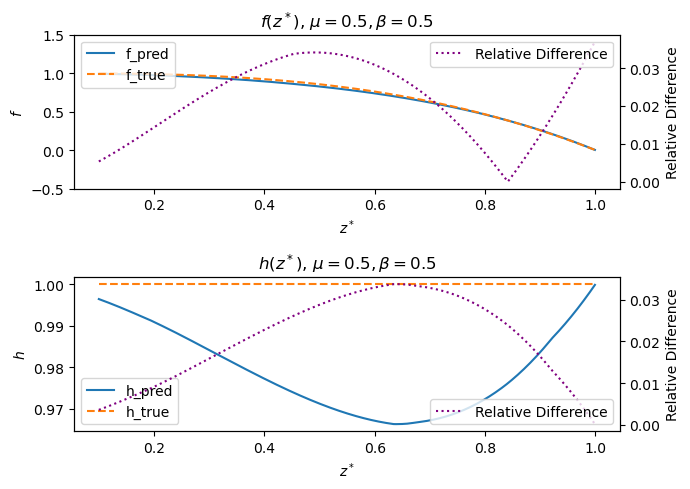

In [93]:
from LinearAxion_NN import _f, _h
from LinearAxion import f, h

zstar_list = torch.tensor(np.linspace(0.10, 0.999, 400), requires_grad=False)

model.eval()
with torch.no_grad():
    f_pred = np.array([_f(model, z).cpu().numpy().squeeze() for z in zstar_list])
    f_true = f(zstar_list, mu, beta)
    h_pred = np.array([_h(model, z).cpu().numpy().squeeze() for z in zstar_list])
    h_true = h(zstar_list)
rel_diff_f = np.abs((f_pred - f_true.detach().cpu().numpy()) / f_true.detach().cpu().numpy())
rel_diff_h = np.abs((h_pred - h_true.detach().cpu().numpy()) / h_true.detach().cpu().numpy())

fig, axs = plt.subplots(2, 1, figsize=(7, 5))
axs[0].plot(zstar_list.detach().cpu().numpy(), f_pred, label="f_pred")
axs[0].plot(zstar_list.detach().cpu().numpy(), f_true.detach().cpu().numpy(), label="f_true", ls="--")
axs[0].set_xlabel("$z^*$")
axs[0].set_ylabel("$f$")
axs[0].set_ylim(-0.5, 1.5)
axs[0].legend(loc='upper left')
ax0twin = axs[0].twinx()
ax0twin.plot(zstar_list.detach().cpu().numpy(), rel_diff_f, label="Relative Difference", color='purple', ls=':')
ax0twin.set_ylabel("Relative Difference")
ax0twin.legend(loc='upper right')
axs[0].set_title(r"$f(z^*)$, $\mu={mu}, \beta={beta}$".format(mu=mu, beta=beta))
axs[1].plot(zstar_list.detach().cpu().numpy(), h_pred, label="h_pred")
axs[1].plot(zstar_list.detach().cpu().numpy(), h_true.detach().cpu().numpy(), label="h_true", ls="--")
axs[1].set_title(r"$h(z^*)$, $\mu={mu}, \beta={beta}$".format(mu=mu, beta=beta))
axs[1].set_xlabel("$z^*$")
axs[1].set_ylabel("$h$")
axs[1].legend(loc='lower left')
ax1twin = axs[1].twinx()
ax1twin.plot(zstar_list.detach().cpu().numpy(), rel_diff_h, label="Relative Difference", color='purple', ls=':')
ax1twin.set_ylabel("Relative Difference")
ax1twin.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [94]:
model.a

Parameter containing:
tensor(-0.0209, requires_grad=True)

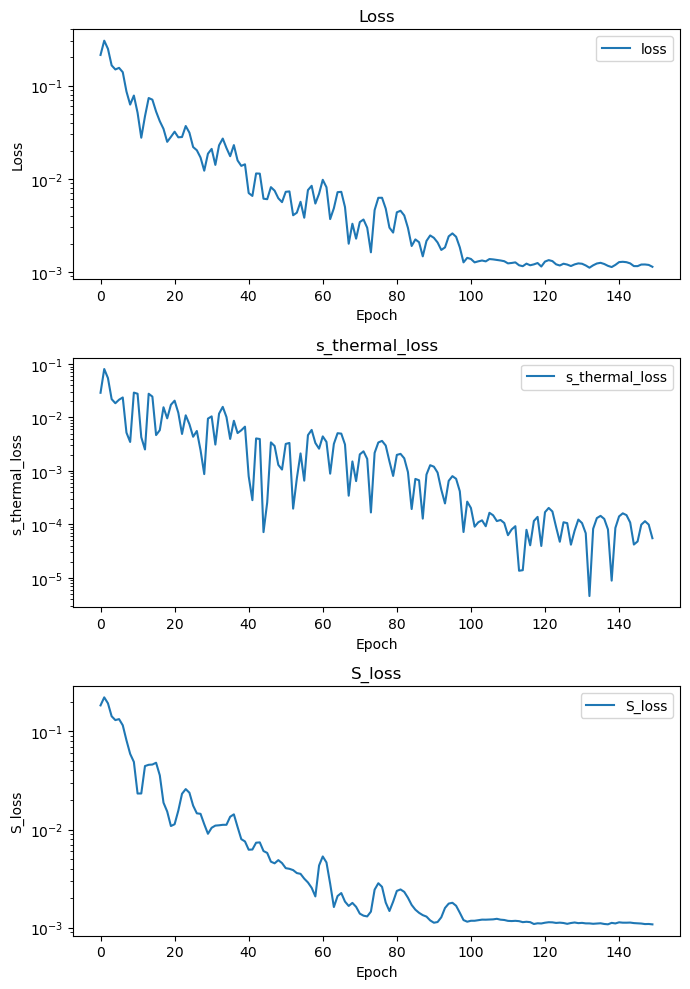

In [95]:
# loss_hist, s_thermal_loss_hist, S_loss_hist, lr_hist
fig, axs = plt.subplots(3, 1, figsize=(7, 10))
axs[0].plot(loss_hist, label="loss")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].set_yscale("log")
axs[1].plot(s_thermal_loss_hist, label="s_thermal_loss")
axs[1].set_title("s_thermal_loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("s_thermal_loss")
axs[1].set_yscale("log")
axs[1].legend()
axs[2].plot(S_loss_hist, label="S_loss")
axs[2].set_title("S_loss")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("S_loss")
axs[2].set_yscale("log")
axs[2].legend()
plt.tight_layout()
plt.show()


# PySR Symbolic Regression

In [96]:
zstars = zstar_list.detach().cpu().numpy()
(f_pred.shape, h_pred.shape, zstars.shape)

((400,), (400,), (400,))

In [97]:
from pysr import PySRRegressor

pysr_model = PySRRegressor(
    binary_operators=["+", "*"],
    # unary_operators=["inv(x) = 1/x"],
    # extra_sympy_mappings={"inv": lambda x: 1/x},
    niterations=1000,
    population_size=100,
    model_selection="best",
    maxsize=20,
    verbosity=1,
)

In [98]:
pysr_model.fit(
    zstars.reshape(-1, 1),
    f_pred,
)

/home/bigbogo/miniconda3/envs/3.10/lib/python3.10/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 5.790e+05
Progress: 959 / 31000 total iterations (3.094%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.758e-02  0.000e+00  y = 0.69253
5           7.468e-03  5.852e-01  y = (x₀ * -1.0177) + 1.2518
7           1.022e-03  9.944e-01  y = ((x₀ * x₀) * -0.9467) + 1.0425
9           1.682e-04  9.021e-01  y = ((x₀ * x₀) * (x₀ * -0.97376)) + 0.96276
11          1.051e-05  1.387e+00  y = ((((x₀ * x₀) * -0.85711) + -0.13689) * x₀) + 1.0056
13          2.336e-06  7.518e-01  y = ((x₀ * (((x₀ * x₀) * -0.43142) + -0.55996)) * x₀) + 0....
                                      99531
15          7.031e-08  1.752e+00  y = ((x₀ * ((x₀ * ((x₀ + -0.45707) * -0.59373)) + -0.67645...
                                      )) * x₀) + 0.99912
17          6.214e-08  6.

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          0.6925339   
	1        0.585150                      (x0 * -1.0177429) + 1.2517833   
	2        0.994422              (x0 * (x0 * -0.94668174)) + 1.0424592   
	3        0.902116       ((x0 * x0) * (x0 * -0.97375745)) + 0.9627552   
	4        1.386601  (((x0 * (x0 * -0.85709465)) + -0.13690427) * x...   
	5        0.751791  (x0 * ((((x0 * x0) * -0.43142462) + -0.5599615...   
	6        1.887550  (((((x0 * -0.6075538) + 0.29520258) * x0) + -0...   
	7  >>>>  0.273824  (((((x0 * -0.6392767) + 0.35272968) * x0) + -0...   
	8        0.036103  (((x0 + -0.033025425) * (((((x0 * -0.61950254)...   
	
	           loss  complexity  
	0  7.757704e-02           1  
	1  7.468328e-03           5  
	2  1.022068e-03           7  
	3  1.682334e-04           9  
	4  1.050813e-05          11  
	5  2.336295e-06          13  
	6  5.358239e-08          15  
	7  3.098715e-08          17  
	8  2.882858e-08          19  
]

  - outputs/20250526_182236_19XNg1/hall_of_fame.csv


The true $f$:
$$1 - \frac{1}{2} \beta^2 z^2 - \left(1 - \frac{1}{2} \beta^2 + \frac{1}{4}\mu^2\right) z^3 + \frac{1}{4}\mu^4 z^4$$

In [99]:
import sympy as sp
from LinearAxion_NN import f_true
# $$1 - \frac{1}{2} \beta^2 z^2 - \left(1 - \frac{1}{2} \beta^2 + \frac{1}{4}\mu^2\right) z^3 + \frac{1}{4}\mu^4 z^4$$
z_sp = sp.symbols('z')
mu_sp = sp.symbols('mu')
beta_sp = sp.symbols('beta')
f_true_sympy = 1 - (1/2) * beta_sp**2 * z_sp**2 - (1 - (1/2) * beta_sp**2 + (1/4) * mu_sp**2) * z_sp**3 + (1/4) * mu_sp**4 * z_sp**4

In [100]:
# set mu=0.5, beta=0.5
f_true_sympy.subs({mu_sp: 0.5, beta_sp: 0.5})

0.015625*z**4 - 0.9375*z**3 - 0.125*z**2 + 1

In [101]:
pysr_f = pysr_model.get_best().sympy_format
# simplify the equation
pysr_f_simplified = sp.simplify(pysr_f)
# expand
pysr_f_simplified = sp.expand(pysr_f_simplified)
print("PySR f equation:")
print(pysr_f_simplified)

PySR f equation:
-0.6392767*x0**4 + 0.368357962415094*x0**3 - 0.745049318995618*x0**2 + 0.018003278754684*x0 + 0.9977671


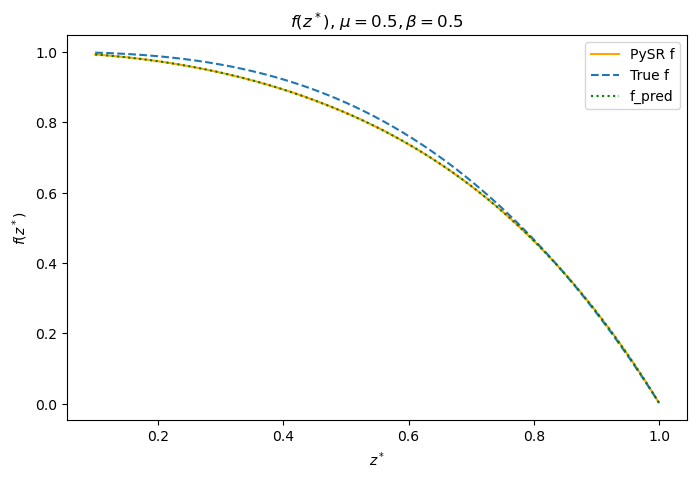

In [102]:
# plot the PySR f equation, the NN f, and the true f equation
zstars_fine = np.linspace(0.1, 0.999, 1000)
f_pred_fine = np.array([pysr_f_simplified.subs({"x0": z, mu_sp: mu, beta_sp: beta}) for z in zstars_fine])
f_true_fine = f_true(torch.tensor(zstars_fine), mu, beta).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
plt.plot(zstars_fine, f_pred_fine, label="PySR f", color='orange')
plt.plot(zstars_fine, f_true_fine, label="True f", ls="--")
plt.plot(zstar_list.detach().cpu().numpy(), f_pred, label="f_pred", color="green", ls=':')
plt.xlabel("$z^*$")
plt.ylabel("$f(z^*)$")
plt.title(r"$f(z^*)$, $\mu={mu}, \beta={beta}$".format(mu=mu, beta=beta))
plt.legend()
plt.show()